# HuBMAP masks and probability density function

> Idea: Knowing that the glomeruli are mainly found in the cortex, we should focus on this region during training.

## Background

A glomerulus is a network of small blood vessels located at the beginning of a nephron in the kidney ([Wikipedia](https://en.wikipedia.org/wiki/Glomerulus_(kidney))). Glomeruli are mainly found in the renal **cortex**, while the renal **medulla** contains mainly the renal tubule. Since we are dealing with biological structures, the separation is not not absolute and the transitions are not always perfectly sharp.

![Diagram of a nephron](http://s3-us-west-2.amazonaws.com/courses-images/wp-content/uploads/sites/1842/2017/05/26234530/m9skcbftjqzrokkkopam.png)
[Diagram of a nephron from libretexts.org, Introductory and General Biology](https://bio.libretexts.org/Bookshelves/Introductory_and_General_Biology/Book%3A_General_Biology_(Boundless)/41%3A_Osmotic_Regulation_and_the_Excretory_System/41.4%3A_Human_Osmoregulatory_and_Excretory_Systems/41.4B%3A_Nephron%3A_The_Functional_Unit_of_the_Kidney)

## Key Idea

A common approach to deal with the very large (>500MB - 5GB) TIFF files in the dataset is to decompose the images in smaller patches/tiles, for instance by using a sliding window apporach.
> **Knowing that the glomeruli are mainly found in the cortex, we should focus on this region during training**. 

Instead of preprocessing the images by saving them into fixed tiles, we prepare the data to sample random tiles from the entire images with a higher probability to sample tiles that contain glomeruli and cortex.

**We combine two sampling apporaches**

> 1. Sampling tiles that contain all glomeruli - this ensures that each glomerulus is seen during one epoch of training at least once. 
> 2. Sampling random tiles based on region probabilites (e.g., medulla; cortex)

*Note: We startet out by only using the second approach (see our public kernel https://www.kaggle.com/matjes/hubmap-labels-pdf-0-5-0-25-0-01). However, we realized that due to the randomness of the sampling sometimes not all glomeruli were drawn during training. Thus, we added the first step.*

## Advantages of this approaches

In combination with [deepflash2](https://github.com/matjesg/deepflash2/tree/master/) and the deepflash2 [pytorch datasets](https://matjesg.github.io/deepflash2/data.html#Datasets) in particular, this approach has several advantages:
- no preprocessing of the data (only saving them to .zarr files for memory efficient loading)
    - flexible tile shapes (input shapes, e.g. 1024, 512, 256) at runtime
    - flexible scaling (e.g., by facors of 2,3,4)
- faster convergence during traing
    - focusing on the relevant regions (e.g., tiles that contain glomeruli and cortex)
    - "additional" data augmentation from random sampling (compared to fixed windows)

## Implementation (masks and probability density function)

The data preprocessing steps in this notebook comprise
- Creating segmentations masks from RLE
- Creating a data frame containing position information on each glomerulus in the segmentation mask
- Creating probability density function (PDF) for efficient sampling from mask and anatmical structure

**Inputs**
- RLE glomeruli segmentations ([challenge dataset](https://www.kaggle.com/c/hubmap-kidney-segmentation/data))
- Anatomical region masks ([.zarr converted](https://www.kaggle.com/matjes/hubmap-pdf-zarr))
   
**Settings**

- Probability for cortex regions (`cortex_p`): 0.7 
- Probability for medulla regions (`medulla_p`): 0.2
- Probability for other regions (`bg_p` (background)): 0.1    

We chose the region sampling probabilites based on expert knowledge and some experiements. However, these settings are hyperparamteres that can be tuned or adjusted if the unterlying data changes.


In [1]:
# Install zarr and load packages
!pip install -qq zarr
import cv2, zarr, gc
import matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
gc.enable()

In [2]:
# from https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T

Settings

In [3]:
class CONFIG:
    path = Path('/kaggle/input/hubmap-kidney-segmentation')
    anatomy = '../input/hubmap-anatomy-zarr/anatomy'
    
    scale = 2        # Downscale final mask by factor 2
    cdf_size = 512   # Downscale CDF for memory efficient loading during training
    bg_p = 0.1       # Background Probability
    cortex_p = 0.7   # Cortex Probability
    medulla_p = 0.2  # Medulla Probability
    
cfg = CONFIG()

**Load inputs and define outputs**

In [4]:
# Input 
df_train = pd.read_csv(cfg.path/"train.csv",index_col='id')
df_info = pd.read_csv(cfg.path/"HuBMAP-20-dataset_information.csv")
grp_pdf = zarr.open_group(cfg.anatomy) # Anatomy labels sever as basis for PDF

# Output
root = zarr.group(f'/kaggle/working/masks_scale{cfg.scale}')
# Saving cdf in 'pdfs' due to naming conventions for sampling during training in deepflash2
g_msk, g_pdf, g_cdf = root.create_groups('labels', 'pdfs', 'cdfs', overwrite=True)

**Loop over files to create...**
1. The segmentation mask (.zarr)
1. A list of glomeruli for *glomeruli sampling*
1. The probability density function for *region sampling*

2f6ecfcdf with shape (31278, 25794)
Scaling to (12897, 15639)
Getting glomeruli stats
Found 161 glomeruli


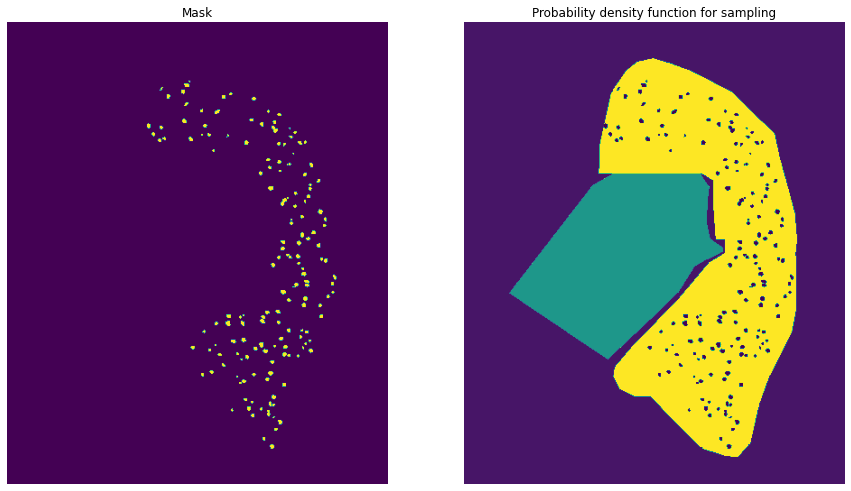

8242609fa with shape (31299, 44066)
Scaling to (22033, 15649)
Getting glomeruli stats
Found 586 glomeruli


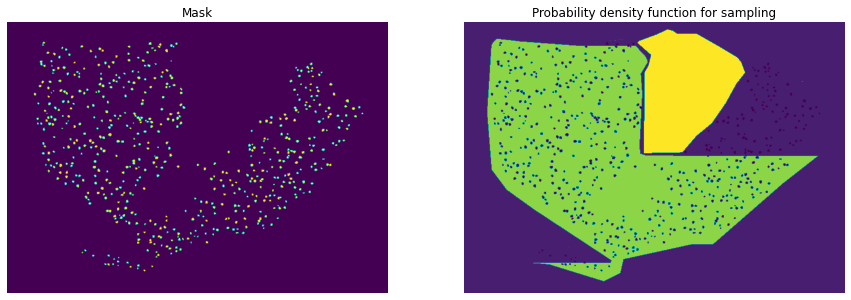

aaa6a05cc with shape (18484, 13013)
Scaling to (6506, 9242)
Getting glomeruli stats
Found 100 glomeruli


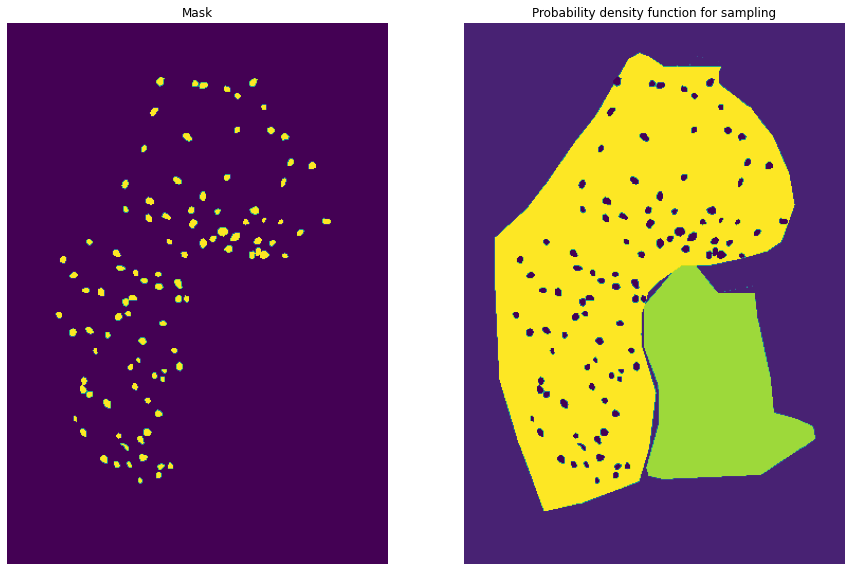

cb2d976f4 with shape (34940, 49548)
Scaling to (24774, 17470)
Getting glomeruli stats
Found 320 glomeruli


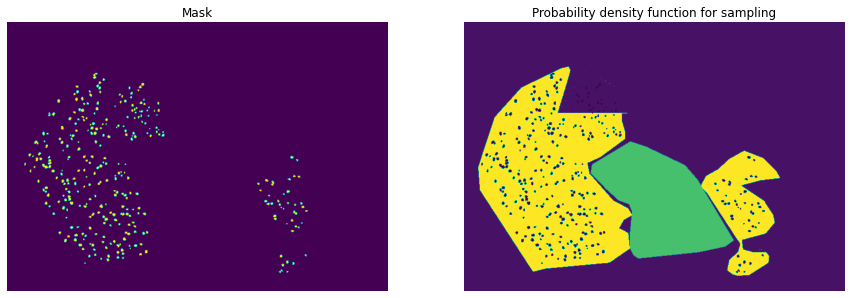

b9a3865fc with shape (31295, 40429)
Scaling to (20214, 15647)
Getting glomeruli stats
Found 466 glomeruli


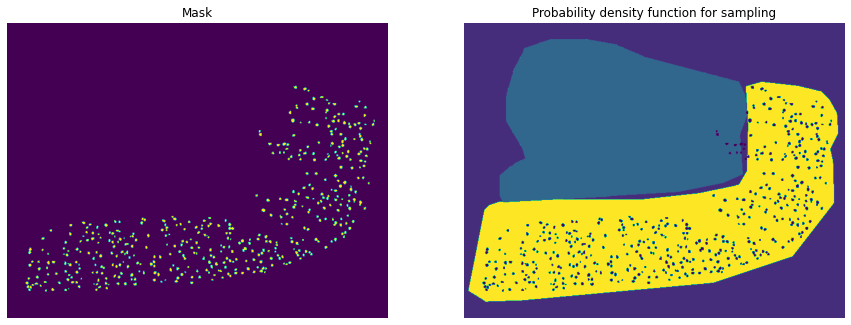

b2dc8411c with shape (14844, 31262)
Scaling to (15631, 7422)
Getting glomeruli stats
Found 136 glomeruli


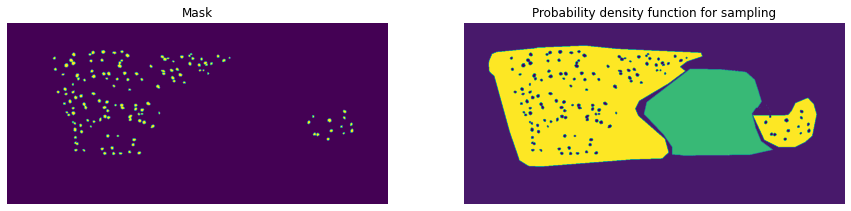

0486052bb with shape (25784, 34937)
Scaling to (17468, 12892)
Getting glomeruli stats
Found 131 glomeruli


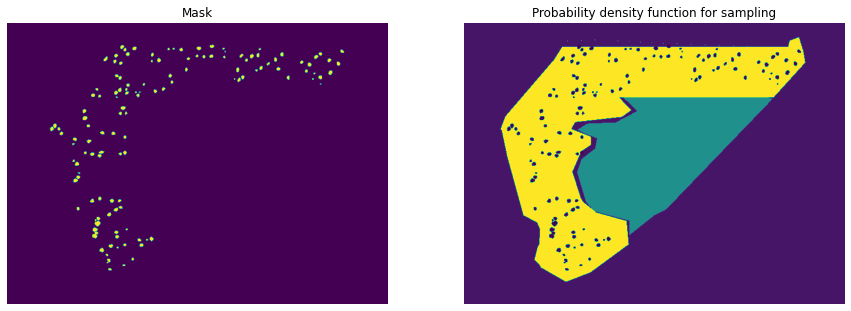

e79de561c with shape (16180, 27020)
Scaling to (13510, 8090)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Getting glomeruli stats
Found 180 glomeruli


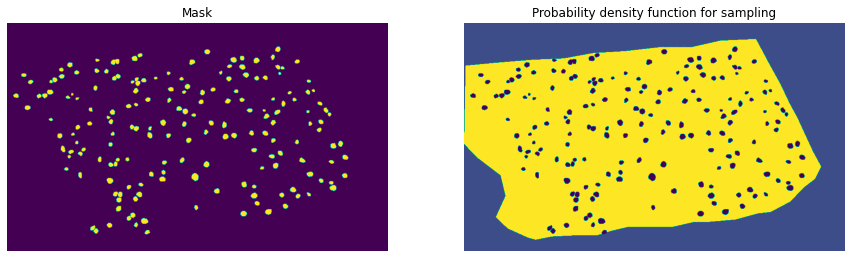

095bf7a1f with shape (38160, 39000)
Scaling to (19500, 19080)
Getting glomeruli stats
Found 347 glomeruli


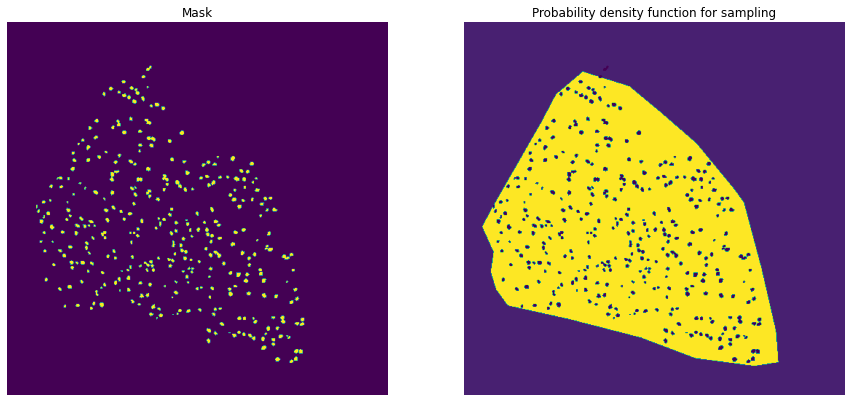

54f2eec69 with shape (30440, 22240)
Scaling to (11120, 15220)
Getting glomeruli stats
Found 140 glomeruli


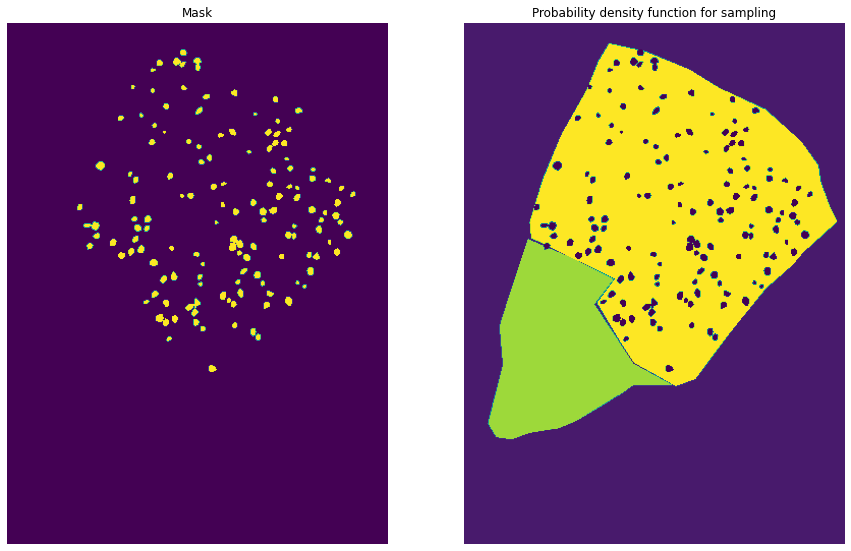

4ef6695ce with shape (39960, 50680)
Scaling to (25340, 19980)
Getting glomeruli stats
Found 439 glomeruli


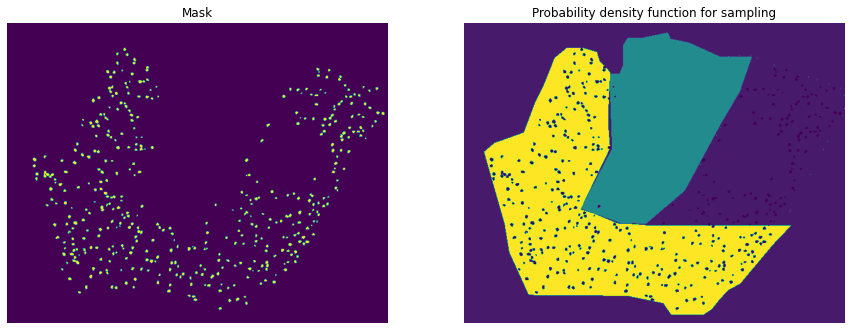

26dc41664 with shape (38160, 42360)
Scaling to (21180, 19080)
Getting glomeruli stats
Found 244 glomeruli


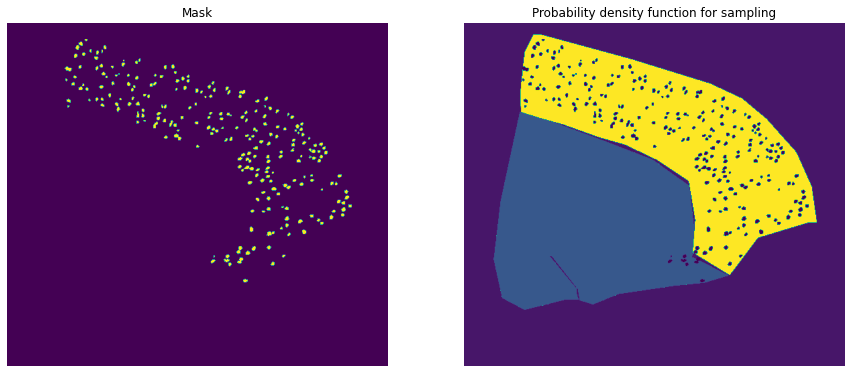

c68fe75ea with shape (26840, 49780)
Scaling to (24890, 13420)
Getting glomeruli stats
Found 118 glomeruli


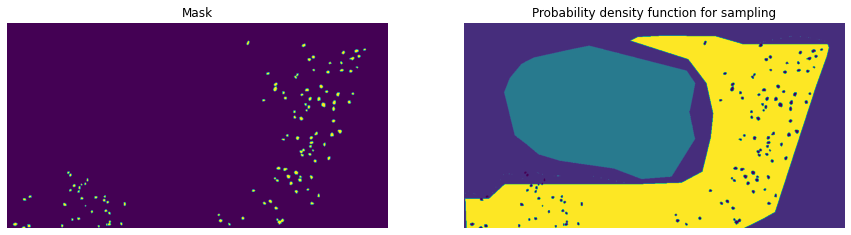

afa5e8098 with shape (36800, 43780)
Scaling to (21890, 18400)
Getting glomeruli stats
Found 234 glomeruli


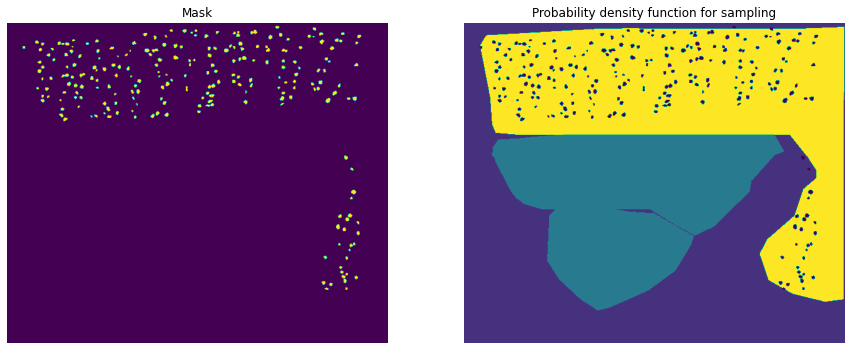

1e2425f28 with shape (26780, 32220)
Scaling to (16110, 13390)
Getting glomeruli stats
Found 179 glomeruli


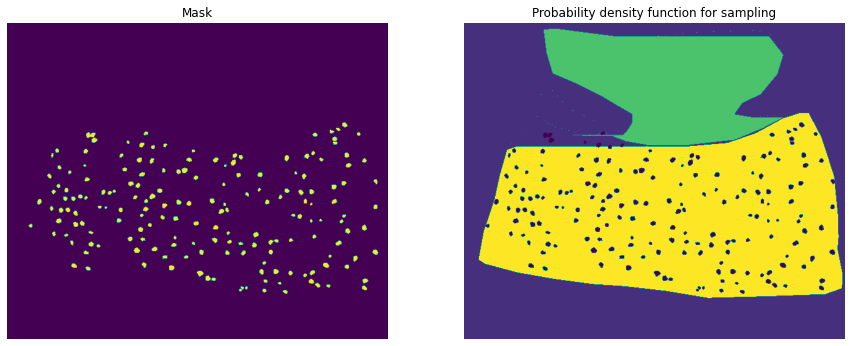

cy            cx   left    top  width  height  \
idx       index                                                            
2f6ecfcdf 0       6185.563702   2002.304985   6149   1970     66      62   
          1       6083.822111   2132.082248   5994   2064    182     136   
          2       5226.641731   2261.644542   5180   2194     97     136   
          3       5958.549694   2350.953992   5886   2275    144     156   
          4       7570.620290   2431.347669   7503   2378    128      97   
...                       ...           ...    ...    ...    ...     ...   
1e2425f28 173     9951.864195  11223.956479   9875  11144    152     147   
          174    10120.264892  11224.335254  10057  11156    124     133   
          175    10880.806311  11337.982930  10787  11258    187     164   
          176     9868.803057  11322.052234   9807  11267    123     114   
          177    11773.816389  11394.827952  11672  11310    203     171   

                  area  
idx       index         
2f6ecfcdf 0       3069  
          1      19113  
          2       8181  
          3      17497  
          4       9394  
...                ...  
1e2425f28 173    13350  
          174    12322  
          175    21266  
          176    10338  
          177    23784  

[3766 rows x 7 columns]

In [5]:
df_list = []
for idx, row in df_train.iterrows():
    
    # Get image info
    img_info = df_info[df_info.image_file==f'{idx}.tiff']
    shape = (img_info.height_pixels.values[0], img_info.width_pixels.values[0])
    print(idx, 'with shape', shape)
    
    msk = rle2mask(row.encoding, (shape[1], shape[0])).astype('uint8')
    
    # Plot
    fig, ax = plt.subplots(ncols=2, figsize=(15,15))
    resize_w = int((msk.shape[1]/msk.shape[0])*cfg.cdf_size)
    ax[0].imshow(cv2.resize(msk, dsize=(resize_w, cfg.cdf_size)))
    ax[0].set_title('Mask')
    ax[0].set_axis_off()
    
    pdf = grp_pdf[idx][:]
    
    if cfg.scale!=1:
        new_size = (msk.shape[1] // cfg.scale, msk.shape[0] // cfg.scale)
        print('Scaling to', new_size)
        msk = cv2.resize(msk, new_size)
        pdf = cv2.resize(pdf, new_size)
        
    pdf = pdf.astype('float32')          
    pdf[pdf==0] = cfg.bg_p/np.sum(pdf==0)
    pdf[msk>0] = 0
    pdf[pdf==1] = cfg.cortex_p/np.sum(pdf==1)
    pdf[pdf==2] = cfg.medulla_p/np.sum(pdf==2)    
      
    print('Getting glomeruli stats')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(msk, connectivity=4)
    print(f'Found {nb_components} glomeruli')
    df_centroids = pd.DataFrame(centroids[1:], columns=['cy', 'cx'])
    df_centroids = df_centroids.join(pd.DataFrame(stats[1:], columns=['left', 'top', 'width', 'height', 'area']))
    df_centroids['idx'] = idx 
    df_centroids.reset_index(inplace=True)
    df_centroids.set_index(['idx', 'index'], inplace=True)
    df_list.append(df_centroids)
    
    # Saving 
    g_msk[idx] = msk
    g_pdf[idx] = pdf
    
    # Saving cdf
    pdf = cv2.resize(pdf, dsize=(resize_w, cfg.cdf_size))      
    g_cdf[idx] = np.cumsum(pdf/np.sum(pdf)) 
            
    ax[1].imshow(pdf)
    ax[1].set_title('Probability density function for sampling')
    ax[1].set_axis_off() 
    plt.show()


df_stats = pd.concat(df_list)
df_stats.to_csv(f'/kaggle/working/masks_scale{cfg.scale}/roi_stats.csv')
df_stats